In [46]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io 
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, cv2

# packages needed for making a dataset: 
from torch.utils.data import DataLoader
from torchvision import transforms

from diffuser_utils import *
import dataset as ds
import models.spectral_model as sm
import models.machinelearning_forward as fm
import spectral_diffusercam_utils.helper_functions as helper

from datetime import date, datetime

import sys
sys.path.append("..")

from models.unet import Unet
import models.unet3d as Unet3d


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import dataset_helper_functions.read_pca_data as rpca
import csv

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "1" #choose the number of gpu that's free. It goes from 0-3

device = 'cuda:0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# pull ds into fruitset
fruitset_pca = glob.glob('/home/cfoley_waller/defocam/defocuscamdata/sample_data/fruitdata/pca/*.mat')
fruitset_cspace = glob.glob('/home/cfoley_waller/defocam/defocuscamdata/sample_data/fruitdata/cspaces/*.mat')
apple = glob.glob('/home/cfoley_waller/defocam/defocuscamdata/sample_data/fruit/*.mat')
all_files_summer = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')
paviaU = glob.glob('/home/cfoley_waller/defocam/defocuscamdata/sample_data/paviadata/*.mat')


In [48]:
### load pavia image
pavia_test_data = ds.SpectralDataset(paviaU, transforms.Compose([ds.subImageRand(),
                                                                   ds.chooseSpectralBands(), 
                                                                   ds.Normalize(), 
                                                                   ds.toTensor()]), tag = 'paviaU')
#load fruit pca data
fruit_train_data = ds.SpectralDataset(fruitset_pca, transforms.Compose([ds.readCompressed(),
                                                                       ds.Resize(),
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(), 
                                                                       ds.Normalize(), 
                                                                       ds.toTensor()]))
summer_train_data = ds.SpectralDataset(all_files_summer, transforms.Compose([ds.Resize(), 
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(),
                                                                       ds.Normalize(),
                                                                       ds.toTensor()]), tag = 'ref')
train_data = ds.Wrapper([summer_train_data, fruit_train_data])

In [49]:
print(len(train_data), len(pavia_test_data))

92 4


In [50]:
# define fwd model
mask = load_mask()
num_images = len(fruit_train_data)
num_inputs_simult = 3
blur_type = 'asymmetric'
optimize_blur = False
forward_model = fm.Forward_Model(
    mask,
    num_ims = num_inputs_simult,
    simulate_blur=False,
    psf_dir = '/home/cfoley_waller/defocam/defocuscamdata/calibration_data/psfs2',
    cuda_device=device,
  )

optimize blur False


In [51]:
#forward model working check 
fruit_dataloader = DataLoader(fruit_train_data, batch_size = 1, shuffle = True)
train_dataloader = DataLoader(train_data, batch_size = 1, shuffle = True)

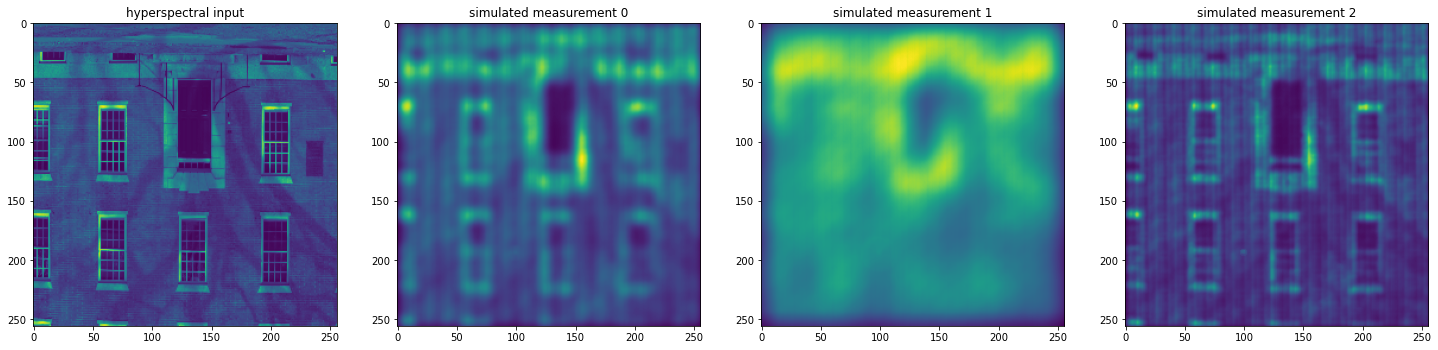

In [52]:
image_tensor_1 = None
for i, sample in enumerate(train_dataloader): 
    if i > 0:
        image_tensor_2 = sample['image']
        image_tensor = torch.stack((image_tensor_1, image_tensor_2),1)[0]
        simulated_meas = forward_model(image_tensor.to(device), sim = True)
        # plt.imshow(np.mean(image_tensor[0].detach().cpu().numpy(),0)) # working!
        # plt.imshow(np.mean(simulated_meas[0][1].detach().cpu().numpy(),0))

        image_np = image_tensor[0].numpy().transpose(1,2,0)
        fig, ax = plt.subplots(1,1 + num_inputs_simult, figsize = (25,10))
        ax[0].imshow(np.mean(image_np,-1)); 
        ax[0].set_title('hyperspectral input')
        for j in range(0,num_inputs_simult):
            ax[1+j].imshow(np.mean(simulated_meas[0].detach().cpu().numpy()[j],0)) # np.mean( .transpose(1,2,0),-1)
            ax[1+j].set_title('simulated measurement '+ str(j))
        plt.show()
        if i == 1:
            break
    else:
        image_tensor_1 = sample['image']

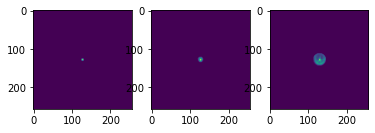

In [53]:
fig, ax = plt.subplots(1,num_inputs_simult)
for j in range(0,num_inputs_simult):
    ax[j].imshow(forward_model.psfs[j].detach().cpu().numpy()); 

In [54]:
#Train model
#1.) make save folder
args_dict = {'version': '3', 'number_measurements': str(num_inputs_simult),
        'blur_type': "measured_blur"}
save_folder = 'saved_models/checkpoint_'+"_".join(list(args_dict.values())) + '/'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

#2.) define recon model 
recon_model = Unet3d.Unet(n_channel_in=num_inputs_simult, n_channel_out=1) #Unet or Unet3d.Unet
recon_model.to(device)
model = sm.MyEnsemble(forward_model.to(device), recon_model.to(device))
if optimize_blur == False:
    model.model1.w_blur.requires_grad = False

#3.) define loss parameters
from torch.nn import MSELoss, L1Loss, CosineSimilarity
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss() #CosineSimilarity() #L1Loss() 
optimizer = Adam(model.parameters(), lr=0.001) #initially set to 0.001
        
print(model.model1.simulate_blur)
print(model.model1.psfs.shape)

False
torch.Size([3, 256, 256])


In [55]:
#4.) Define pavia data as test data. 
pavia_dataloader = DataLoader(pavia_test_data, batch_size=1, shuffle=True)

def run_test():
    test_loss = 0
    sample_np = None
    for sample in pavia_dataloader:
        sample_np = sample['image'].numpy()[0]
        output = model(sample['image'].to(device))   # Compute the output image 
        loss = loss_function(output, sample['image'].to(device)) # Compute the loss
        test_loss += loss.item()
    test_loss = test_loss/pavia_dataloader.__len__()
    test_np = output.detach().cpu().numpy()[0]
        
    return test_loss, test_np, sample_np

In [56]:
epochs = 2000 
offset = 0
w_list = []
test_loss_list = []
train_loss_list = []
print('training')

for i in range(epochs): # Outerloop with epochs
    train_loss = 0
    
    for current ,sample in enumerate(train_dataloader):   # Training Loop (go through each image in the training set)
        helper.show_progress_bar(train_dataloader, current)
        
        output = model(sample['image'].to(device))   # Compute the output image 
        ground_padded = model.spectral_pad(sample['image'].to(device), spec_dim = 2, size = 2)
        loss = loss_function(output, sample['image'].to(device)) # Compute the loss
        train_loss += loss.item()
        
        # Update the model based on the loss
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        net_output_np = output.detach().cpu().numpy()[0]
        sim_meas_np = model.output1.detach().cpu().numpy()[0]
        
        #break 
    
    train_loss_list.append(train_loss/train_data.__len__())
    
    #testing
    test_loss = 0
    if i % 10 == 0:# and not i == 0:
        test_loss, test_np, ground_truth_np = run_test()
        test_loss_list.append(test_loss)
        
        #show test recon next to ground truth
        print("Total Test Loss (", i, "): \t", round(test_loss_list[-1], 4))
        fig,ax = plt.subplots(1,2,figsize = (15,5))
        ax[0].imshow(np.mean(test_np, 0), cmap = 'RdBu')
        ax[0].set_title('reconstructed')
        ax[1].imshow(np.mean(ground_truth_np,0), cmap = 'RdBu')
        ax[1].set_title('ground truth')
        
        plt.show()
        torch.save(model.state_dict(), save_folder + 'saved_model_' 'ep'+str(i)+'_testloss_'+str(test_loss) + '.pt')
        scipy.io.savemat(save_folder+'saved_lists.mat', 
                         {'test_loss': test_loss_list,
                         'train_loss': train_loss_list,
                         'w_list': w_list})
    test_loss_list.append(test_loss)
        
    #show train recon next to masks
    print("Total Train Loss (", i, "):", round(train_loss_list[-1], 4),
         " \t Blur (",model.model1.blur_type ,"):", model.model1.w_blur.data.detach().cpu().numpy())
    fig, ax = plt.subplots(1,num_inputs_simult+2, figsize = (15,5))
    ax[0].imshow(np.mean(net_output_np,0)) #np.mean(a,0) averages spec channels
    ax[0].set_title('avg of reconstructed channels')
    for j in range(0,num_inputs_simult):
        ax[j+1].imshow(np.mean(sim_meas_np[j],0))
        ax[j+1].set_title(f'simulated image {j+1}')
    ax[-1].imshow(model.model1.psfs[1].detach().cpu().numpy()) #blurry psf
    ax[-1].set_title(f'blurry psf, learned:{optimize_blur}')
    plt.show()
    
    #save model state
    torch.save(model.state_dict(), save_folder + 'saved_model_' 'ep'+str(i + offset)+'_testloss_'+str(test_loss) + '.pt')
    scipy.io.savemat(save_folder+'saved_lists.mat', 
                     {'test_loss': test_loss_list,
                     'train_loss': train_loss_list,
                     'w_list': w_list})

training


KeyError: 'paviaU'